## Experiments for labeling furniture images

In [3]:
import time
import torch
from PIL import Image
from datasets import load_dataset
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.float16,
     attn_implementation="flash_attention_2",
    device_map="auto",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
import json

def convert_string_to_json(input_list):
    json_string = input_list[0]
    cleaned_string = json_string.replace('\\n', '')
    json_object = json.loads(cleaned_string)
    
    return json_object

{
  "type": "chair",
  "style": "modern",
  "color": "gray",
  "material": "fabric",
  "shape": "square",
  "size": "medium",
  "details": "solid",
  "pattern": "solid",
  "texture": "smooth"
}
Processing time: 2.91 seconds
--------------------
File path: /home/s464915/future-designer/dataset/chair/Anish Upholstered Armchair_1.jpg


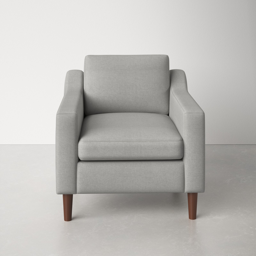

In [5]:
file_path = '/home/s464915/future-designer/dataset/train/chair/Anish Upholstered Armchair_1.jpg'

image = Image.open(file_path)

conversation = [
        {
        "role": "system",
        "content": "You are a furniture expert. Analyze the image and provide a detailed description in JSON format."
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text", "text": """Describe the furniture in the image using the following JSON structure. 
                                        Please make sure to use only one word and be really specific, my job depends on it. 
                                        If any field is not applicable or cannot be determined, use "N/A".
                    {
                        "type": "main furniture type (only: bed, chair, table, sofa)",
                        "style": "overall style (e.g., modern, traditional, rustic)",
                        "color": "main color",
                        "material": "primary material",
                        "shape": "general shape",
                        "size": "size category (e.g., small, medium, large)",
                        "details": "any decorative features",
                        "pattern": "surface pattern (e.g., solid, striped, floral)",
                        "texture": "surface texture (e.g., smooth, rough, woven)"
                    }
            """},
        ],
    }
]

text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

start_time = time.time()

# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)

end_time = time.time()
processing_time = end_time - start_time

# Convert to JSON
result = convert_string_to_json(output_text)

print(json.dumps(result, indent=2))
print(f"Processing time: {processing_time:.2f} seconds")
print("--------------------")
print(f"File path: {file_path}")

image.resize((256, 256))

In [12]:
import json
from typing import Any, Dict, List

class LabelGenerator:
    def __init__(self, 
                 model: Any, 
                 processor: Any, 
                 prompt: List[Dict[str, str]]) -> None:
        """
        Initialize the LabelGenerator.

        Args:
            model: The vision-language model to use for generation
            processor: The processor for preparing inputs
            prompt: The text prompt template to use
        """
        self.model = model
        self.processor = processor
        self.prompt = prompt

    def __call__(self, image: Image) -> Dict:
        return self.get_labels(image)

    def get_labels(self, image: Image) -> Dict:
        """
        Generate labels for an image using the specified prompt.

        Args:
            image: The input image
            prompt: The text prompt to use

        Returns:
            Dict: Generated labels in JSON format
        """
        text_prompt = self.processor.apply_chat_template(self.prompt, 
                                                         add_generation_prompt=True)
        inputs = self.processor(
            text=[text_prompt],
            images=[image],
            padding=True,
            return_tensors="pt"
        ).to("cuda")

        output_ids = self.model.generate(**inputs, max_new_tokens=128)
        
        generated_ids = [
            output_ids[i][len(input_ids):]
            for i, input_ids in enumerate(inputs.input_ids)
        ]
        
        output_text = self.processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )

        return self._convert_string_to_json(output_text)

    @staticmethod
    def _convert_string_to_json(input_list: List[str]) -> Dict:
        if input_list[0].startswith("```json\n"): 
            json_string = input_list[0].strip("['```json\n', '\n```']")
        else:
            json_string = input_list[0].replace('\n', '')
        try:
            return json.loads(json_string)
        except json.JSONDecodeError as e:
            raise ValueError(f"Failed to parse model output as JSON: {json_string}") from e

## Creating hugging face dataset

In [8]:
import json
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import os

data = []
generator = LabelGenerator(model, processor, conversation)
classes = ['bed', 'chair', 'table', 'sofa']
base_path = Path('/home/s464915/future-designer/dataset/train')

for class_name in classes:
    class_path = base_path / class_name
    image_files = [f for f in class_path.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    for image_file in tqdm(image_files, desc=f"Processing {class_name} images"):
        try:
            image = Image.open(image_file)
            caption = generator(image)
            
            data.append({
                "file_name": image.filename,  
                "caption": caption,
            })
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue

output_path = "/home/s464915/future-designer/furniture_captions_dataset/metadata.jsonl"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, "w") as f:
    for item in data:
        f.write(json.dumps(item) + "\n")

print(f"Processed {len(data)} images total")

Processing table images:   2%|▏         | 6/260 [00:18<15:18,  3.62s/it]

Error processing /home/s464915/future-designer/dataset/train/table/table29.jpg: CUDA out of memory. Tried to allocate 3.57 GiB. GPU 0 has a total capacity of 23.64 GiB of which 1.67 GiB is free. Including non-PyTorch memory, this process has 21.97 GiB memory in use. Of the allocated memory 20.01 GiB is allocated by PyTorch, and 1.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Processing table images:  47%|████▋     | 121/260 [05:26<08:04,  3.49s/it]

Error processing /home/s464915/future-designer/dataset/train/table/table15.jpg: CUDA out of memory. Tried to allocate 3.57 GiB. GPU 0 has a total capacity of 23.64 GiB of which 1.67 GiB is free. Including non-PyTorch memory, this process has 21.97 GiB memory in use. Of the allocated memory 20.01 GiB is allocated by PyTorch, and 1.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Processing table images:  97%|█████████▋| 252/260 [11:18<00:21,  2.70s/it]

Error processing /home/s464915/future-designer/dataset/train/table/table24.jpg: CUDA out of memory. Tried to allocate 2.31 GiB. GPU 0 has a total capacity of 23.64 GiB of which 1.67 GiB is free. Including non-PyTorch memory, this process has 21.97 GiB memory in use. Of the allocated memory 18.43 GiB is allocated by PyTorch, and 3.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Processing sofa images:  31%|███▏      | 89/283 [04:05<11:33,  3.57s/it]

Error processing /home/s464915/future-designer/dataset/train/sofa/sofa1.jpg: CUDA out of memory. Tried to allocate 3.57 GiB. GPU 0 has a total capacity of 23.64 GiB of which 1.67 GiB is free. Including non-PyTorch memory, this process has 21.97 GiB memory in use. Of the allocated memory 20.01 GiB is allocated by PyTorch, and 1.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Processing sofa images: 100%|██████████| 283/283 [12:57<00:00,  2.75s/it]

Processed 1045 images total


In [4]:
dataset = load_dataset("imagefolder", data_dir="/home/s464915/future-designer/dataset")

Resolving data files:   0%|          | 0/1045 [00:00<?, ?it/s]

In [17]:
dataset.push_to_hub("filnow/furniture-captions-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1045 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/filnow/furniture-captions-dataset/commit/d774563a89f2ef6405f8c27f0cb0883be8b08ef4', commit_message='Upload dataset', commit_description='', oid='d774563a89f2ef6405f8c27f0cb0883be8b08ef4', pr_url=None, pr_revision=None, pr_num=None)

## Check how many type labels QWEN got correct with dataset labels

In [31]:
bed_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'bed')
print(f"Number of images where type equals 'bed': {bed_count}")

table_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'table')
print(f"Number of images where type equals 'table': {table_count}")

sofa_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'sofa')
print(f"Number of images where type equals 'sofa': {sofa_count}")

chair_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'chair')
print(f"Number of images where type equals 'chair': {chair_count}")

print(f"Dataset size: {len(dataset['train'])}\n")
print(f"Total number of labels in right category: {bed_count + table_count + sofa_count + chair_count}")


Number of images where type equals 'bed': 188
Number of images where type equals 'table': 256
Number of images where type equals 'sofa': 281
Number of images where type equals 'chair': 319
Dataset size: 1044

Total number of labels in right category: 1044


All images were labeled in categories that matches it initial classes, but there is small missmatch in terms of right categories:

    - Bed 188 should be 187 - 1 more
    - Table 256 should be 258 - 2 less
    - Sofa 283 should be 281 - 2 more
    - Chair 319 should be 320 - 1 less

Let's see what exactly was mis labeled

Image: /home/s464915/future-designer/dataset/train/chair/Brandt Upholstered Swivel Armchair_11.jpg
Initial label: chair
Predicted label: sofa



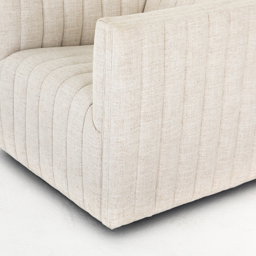

Image: /home/s464915/future-designer/dataset/train/chair/Cache Lounge Chair_6.jpg
Initial label: chair
Predicted label: sofa



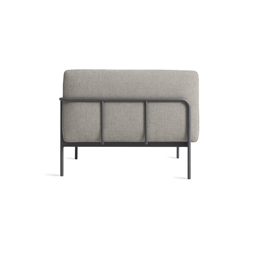

Image: /home/s464915/future-designer/dataset/train/chair/chair117.jpg
Initial label: chair
Predicted label: sofa



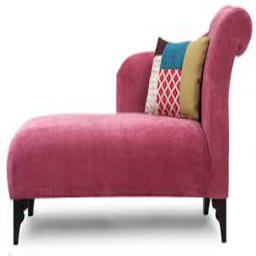

Image: /home/s464915/future-designer/dataset/train/sofa/101 Upholstered Sofa_9.jpg
Initial label: sofa
Predicted label: chair



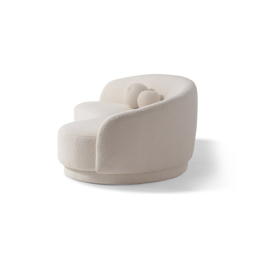

Image: /home/s464915/future-designer/dataset/train/sofa/80 Square Arm Sofa Bed_12.jpg
Initial label: sofa
Predicted label: bed



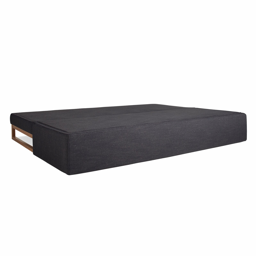

Image: /home/s464915/future-designer/dataset/train/sofa/80 Square Arm Sofa Bed_13.jpg
Initial label: sofa
Predicted label: chair



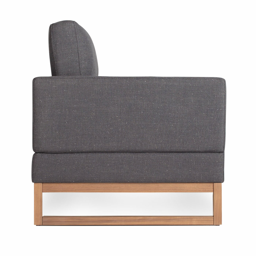

Image: /home/s464915/future-designer/dataset/train/sofa/80 Square Arm Sofa Bed_8.jpg
Initial label: sofa
Predicted label: bed



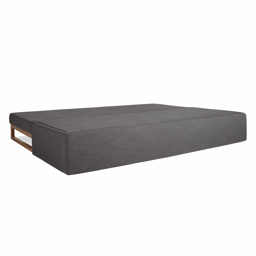

Image: /home/s464915/future-designer/dataset/train/sofa/Anse 67 Upholstered Sofa_3.jpg
Initial label: sofa
Predicted label: chair



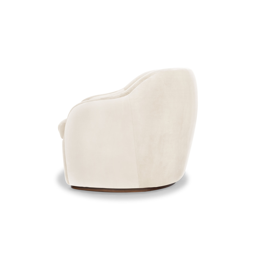

Image: /home/s464915/future-designer/dataset/train/table/Afeefah Nesting Coffee Table_1.jpg
Initial label: table
Predicted label: sofa



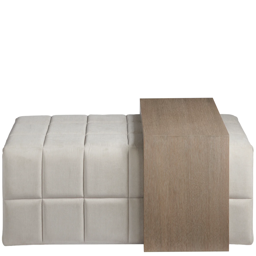

: 

In [5]:
for item in dataset['train']:
    if not hasattr(item['image'], 'filename'):
        continue
    else:
        path = item['image'].filename

    initial_label = path.split('/')[-2]

    if item['caption']['type'] != initial_label:
        print(f"Image: {path}")
        print(f"Initial label: {initial_label}")
        print(f"Predicted label: {item['caption']['type']}\n")
        Image.open(path).resize((256, 256)).show()


There is 9 misslabeled objects, accuracy:

1044 - 9 = 1035 - correctly labeled

1035/1044 * 100 = 99.14%

Therefore, the accuracy of the labeling is 99.14%.

## Experiments with QWEN 2 VL 2B

In [1]:
import time
import torch
from PIL import Image
from datasets import load_dataset
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.float16,
     attn_implementation="flash_attention_2",
    device_map="auto",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

['```json\n{\n  "type": "chair",\n  "style": "modern",\n  "color": "light gray",\n  "material": "fabric",\n  "shape": "square",\n  "size": "medium",\n  "details": "smooth, padded seat and backrest",\n  "pattern": "solid",\n  "texture": "smooth"\n}\n```']
{
  "type": "chair",
  "style": "modern",
  "color": "light gray",
  "material": "fabric",
  "shape": "square",
  "size": "medium",
  "details": "smooth, padded seat and backrest",
  "pattern": "solid",
  "texture": "smooth"
}
Processing time: 2.94 seconds
--------------------
File path: /home/s464915/future-designer/dataset/train/chair/Anish Upholstered Armchair_1.jpg


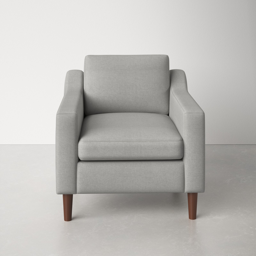

In [11]:
def convert_to_json(input_str):
    json_str = input_str[0].strip("['```json\n', '\n```']")
    json_obj = json.loads(json_str)
    
    return json_obj


file_path = '/home/s464915/future-designer/dataset/train/chair/Anish Upholstered Armchair_1.jpg'

image = Image.open(file_path)



conversation = [
        {
        "role": "system",
        "content": "You are a furniture expert. Analyze the image and provide a detailed description in JSON format."
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text", "text": """Describe the furniture in the image using the following JSON structure. 
                                        Please make sure to use only one word and be really specific, my job depends on it. 
                                        If any field is not applicable or cannot be determined, use "N/A".
                    {
                        "type": "main furniture type (only: bed, chair, table, sofa)",
                        "style": "overall style (e.g., modern, traditional, rustic)",
                        "color": "main color",
                        "material": "primary material",
                        "shape": "general shape",
                        "size": "size category (e.g., small, medium, large)",
                        "details": "any decorative features",
                        "pattern": "surface pattern (e.g., solid, striped, floral)",
                        "texture": "surface texture (e.g., smooth, rough, woven)"
                    }
            """},
        ],
    }
]

text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

start_time = time.time()

# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)

end_time = time.time()
processing_time = end_time - start_time

print(output_text)
# Convert to JSON
result = convert_to_json(output_text[0])

print(json.dumps(result, indent=2))
print(f"Processing time: {processing_time:.2f} seconds")
print("--------------------")
print(f"File path: {file_path}")

image.resize((256, 256))

In [13]:
import json
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import os

data = []
generator = LabelGenerator(model, processor, conversation)
classes = ['bed', 'chair', 'table', 'sofa']
base_path = Path('/home/s464915/future-designer/dataset/train')

for class_name in classes:
    class_path = base_path / class_name
    image_files = [f for f in class_path.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    for image_file in tqdm(image_files, desc=f"Processing {class_name} images"):
        try:
            image = Image.open(image_file)
            caption = generator(image)
            
            data.append({
                "file_name": image.filename,  
                "caption": caption,
            })
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue

output_path = "/home/s464915/future-designer/dataset/train/metadata.jsonl"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, "w") as f:
    for item in data:
        f.write(json.dumps(item) + "\n")

print(f"Processed {len(data)} images total")

Processing sofa images: 100%|██████████| 282/282 [13:10<00:00,  2.80s/it]

Processed 1044 images total


In [17]:
dataset = load_dataset("imagefolder", data_dir="/home/s464915/future-designer/dataset")

bed_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'bed')
print(f"Number of images where type equals 'bed': {bed_count}")

table_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'table')
print(f"Number of images where type equals 'table': {table_count}")

sofa_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'sofa')
print(f"Number of images where type equals 'sofa': {sofa_count}")

chair_count = sum(1 for item in dataset['train'] if item['caption']['type'] == 'chair')
print(f"Number of images where type equals 'chair': {chair_count}")

print(f"Dataset size: {len(dataset['train'])}\n")
print(f"Total number of labels in right category: {bed_count + table_count + sofa_count + chair_count}")

Resolving data files:   0%|          | 0/1045 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Number of images where type equals 'bed': 188
Number of images where type equals 'table': 257
Number of images where type equals 'sofa': 285
Number of images where type equals 'chair': 314
Dataset size: 1044

Total number of labels in right category: 1044


Image: /home/s464915/future-designer/dataset/train/chair/Arlo Genuine Leather Mid Century Arm Chair_4.jpg
Initial label: chair
Predicted label: sofa



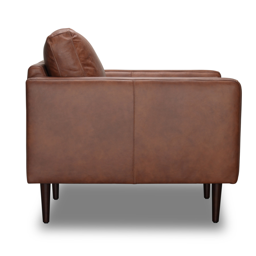

Image: /home/s464915/future-designer/dataset/train/chair/Brandt Upholstered Swivel Armchair_11.jpg
Initial label: chair
Predicted label: sofa



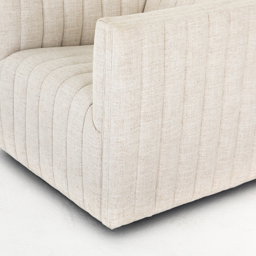

Image: /home/s464915/future-designer/dataset/train/chair/Cache Lounge Chair_6.jpg
Initial label: chair
Predicted label: sofa



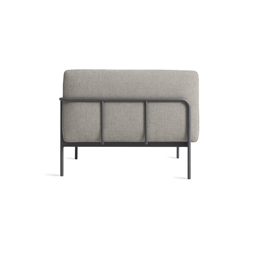

Image: /home/s464915/future-designer/dataset/train/chair/Clifford Leather Armchair_3.jpg
Initial label: chair
Predicted label: sofa



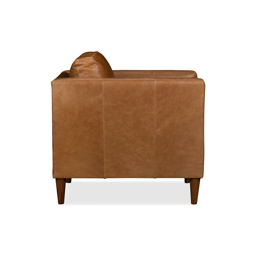

Image: /home/s464915/future-designer/dataset/train/chair/chair117.jpg
Initial label: chair
Predicted label: sofa



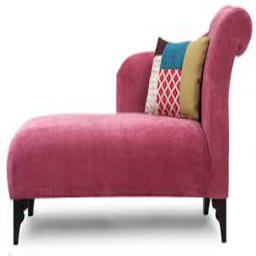

Image: /home/s464915/future-designer/dataset/train/chair/chair162.jpg
Initial label: chair
Predicted label: sofa



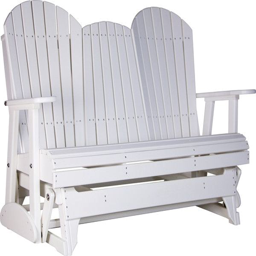

Image: /home/s464915/future-designer/dataset/train/chair/chair179.jpg
Initial label: chair
Predicted label: sofa



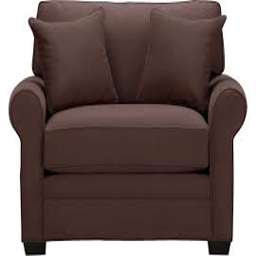

Image: /home/s464915/future-designer/dataset/train/sofa/101 Upholstered Sofa_9.jpg
Initial label: sofa
Predicted label: chair



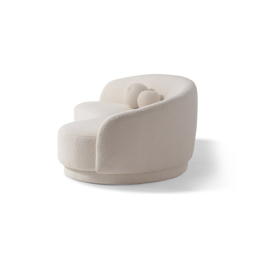

Image: /home/s464915/future-designer/dataset/train/sofa/80 Square Arm Sofa Bed_12.jpg
Initial label: sofa
Predicted label: bed



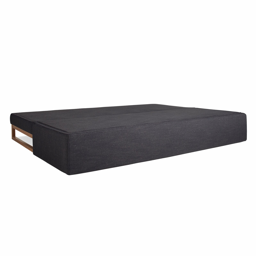

Image: /home/s464915/future-designer/dataset/train/sofa/80 Square Arm Sofa Bed_8.jpg
Initial label: sofa
Predicted label: bed



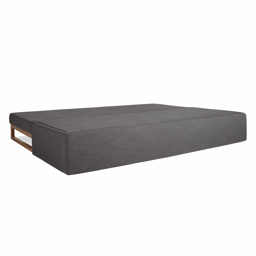

Image: /home/s464915/future-designer/dataset/train/sofa/Anse 67 Upholstered Sofa_3.jpg
Initial label: sofa
Predicted label: chair



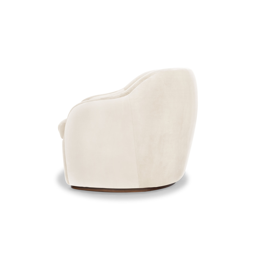

: 

In [18]:
for item in dataset['train']:
    if not hasattr(item['image'], 'filename'):
        continue
    else:
        path = item['image'].filename

    initial_label = path.split('/')[-2]

    if item['caption']['type'] != initial_label:
        print(f"Image: {path}")
        print(f"Initial label: {initial_label}")
        print(f"Predicted label: {item['caption']['type']}\n")
        Image.open(path).resize((256, 256)).show()

In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

# If you want to load a model using multiple GPUs, please refer to the `Multiple GPUs` section.
path = 'OpenGVLab/InternVL2-1B'
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)
model.config.pad_token_id = tokenizer.eos_token_id

/home/s464915/.conda/envs/fude/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
question = 'Hello, who are you?'
generation_config = dict(max_new_tokens=1024, do_sample=True)
response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


User: Hello, who are you?
Assistant: I am an AI language model, designed to provide helpful responses to your questions. How can I assist you today?


In [38]:
import time
import os
import json
from transformers import logging

logging.set_verbosity_error()


def convert_string_to_json(input_list):
        return json.loads(input_list)

file_path = '/home/s464915/future-designer/dataset/train/chair/Anish Upholstered Armchair_1.jpg'

image = Image.open(file_path)

pixel_values = load_image(file_path, max_num=12).to(torch.float16).cuda()
generation_config = dict(max_new_tokens=100, do_sample=True)

question = '''<image>\nDescribe the furniture in the image using the following JSON structure. 
                                        Please make sure to use only one word and be really specific, my job depends on it. 
                                        If any field is not applicable or cannot be determined, use "N/A".
                    {
                        "type": "main furniture type (only: bed, chair, table, sofa)",
                        "style": "overall style (e.g., modern, traditional, rustic)",
                        "color": "main color",
                        "material": "primary material",
                        "shape": "general shape",
                        "size": "size category (e.g., small, medium, large)",
                        "details": "any decorative features",
                        "pattern": "surface pattern (e.g., solid, striped, floral)",
                        "texture": "surface texture (e.g., smooth, rough, woven)"
                    }'''
start_time = time.time()

generation_config = dict(max_new_tokens=128, do_sample=True)
response = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=False)
result = convert_string_to_json(response)

end_time = time.time()
processing_time = end_time - start_time

print(f'{json.dumps(result, indent=2)}')
print(f"Processing time: {processing_time:.2f} seconds")
print("--------------------")
print(f"File path: {file_path}")

image.resize((256, 256))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [2]:
import json
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import os
import time
from transformers import logging

def covert_to_json(input):
    if input.startswith("```json"):
        return json.loads(input.replace("```json", "").replace("```", "").strip())
    return json.loads(input)

logging.set_verbosity_error()
question = '''<image>\nDescribe the furniture in the image using the following JSON structure. 
                                        Please make sure to use only one word and be really specific, my job depends on it. 
                                        If any field is not applicable or cannot be determined, use "N/A".
                    {
                        "type": "main furniture type (only: bed, chair, table, sofa)",
                        "style": "overall style (e.g., modern, traditional, rustic)",
                        "color": "main color",
                        "material": "primary material",
                        "shape": "general shape",
                        "size": "size category (e.g., small, medium, large)",
                        "details": "any decorative features",
                        "pattern": "surface pattern (e.g., solid, striped, floral)",
                        "texture": "surface texture (e.g., smooth, rough, woven)"
                    }'''
data = []
failed_images = []
classes = ['bed', 'chair', 'table', 'sofa']
base_path = Path('/home/s464915/future-designer/dataset/train')
generation_config = dict(max_new_tokens=128, do_sample=True)
MAX_RETRIES = 5

for class_name in classes:
    class_path = base_path / class_name
    image_files = [f for f in class_path.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    for image_file in tqdm(image_files, desc=f"Processing {class_name} images"):
        try:
            image = load_image(image_file, max_num=12).to(torch.float16).cuda()
            caption = model.chat(tokenizer, image, question, generation_config, history=None, return_history=False)

            retry_count = 0
            while retry_count < MAX_RETRIES:
                try:
                    response = covert_to_json(caption)
                    break
                except json.JSONDecodeError:
                    retry_count += 1
                    if retry_count == MAX_RETRIES:
                        failed_images.append((str(image_file), "JSON parsing failed"))
                        print(f"\nFailed after {MAX_RETRIES} attempts for {image_file}")
                        continue
            
            data.append({
                "file_name": image_file,  
                "caption": response
            })
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue

output_path = "/home/s464915/future-designer/dataset/train/metadata.jsonl"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, "w") as f:
    for item in data:
        f.write(json.dumps(item) + "\n")

print(f"Processed {len(data)} images total")

Processing bed images:  18%|█▊        | 34/186 [00:53<03:59,  1.58s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/bed/bed70.jpg


Processing bed images:  46%|████▌     | 85/186 [02:14<02:58,  1.77s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/bed/bed46.jpg


Processing bed images:  63%|██████▎   | 117/186 [03:01<01:49,  1.59s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/bed/bed85.jpg


Processing bed images:  80%|████████  | 149/186 [03:50<00:58,  1.58s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/bed/bed126.jpg


Processing bed images:  90%|█████████ | 168/186 [04:22<00:28,  1.58s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/bed/bed36.jpg


Processing chair images:   2%|▏         | 6/319 [00:09<07:42,  1.48s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/chair151.jpg


Processing chair images:  15%|█▌        | 49/319 [01:16<07:53,  1.75s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/Budliegh Upholstered Armchair_1.jpg


Processing chair images:  24%|██▍       | 77/319 [02:00<06:33,  1.62s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/Conan Upholstered Armchair_1.jpg


Processing chair images:  56%|█████▌    | 178/319 [04:39<03:30,  1.50s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/chair188.jpg


Processing chair images:  57%|█████▋    | 182/319 [04:45<03:26,  1.51s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/chair4.jpg


Processing chair images:  61%|██████▏   | 196/319 [05:08<03:09,  1.54s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/chair124.jpg


Processing chair images:  74%|███████▎  | 235/319 [06:06<01:34,  1.13s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/chair149.jpg


Processing chair images:  96%|█████████▌| 306/319 [07:56<00:20,  1.59s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/Cache Lounge Chair_4.jpg


Processing chair images:  97%|█████████▋| 308/319 [08:00<00:18,  1.66s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/chair/chair200.jpg


Processing table images:  19%|█▉        | 49/257 [01:14<05:16,  1.52s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/table/Aster Coffee Table_4.jpg


Processing table images:  22%|██▏       | 57/257 [01:27<05:22,  1.61s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/table/table84.jpg


Processing table images:  70%|███████   | 181/257 [04:33<01:54,  1.51s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/table/table94.jpg


Processing table images:  71%|███████   | 182/257 [04:33<01:23,  1.12s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/table/Carmyn Coffee Table_10.jpg


Processing table images:  72%|███████▏  | 186/257 [04:40<01:46,  1.49s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/table/Beorn Coffee Table_6.jpg


Processing table images:  83%|████████▎ | 214/257 [05:20<01:04,  1.49s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/table/Circula Large Coffee Table_14.jpg


Processing table images:  93%|█████████▎| 240/257 [05:58<00:24,  1.44s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/table/table92.jpg


Processing sofa images:   6%|▌         | 16/282 [00:24<06:49,  1.54s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/sofa/89 Upholstered Sofa_4.jpg


Processing sofa images:  56%|█████▌    | 158/282 [04:10<02:56,  1.42s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/sofa/Bainton 110 Upholstered Sofa_3.jpg


Processing sofa images:  59%|█████▉    | 167/282 [04:26<03:44,  1.95s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/sofa/sofa70.jpg


Processing sofa images:  62%|██████▏   | 176/282 [04:41<03:04,  1.74s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/sofa/sofa86.jpg


Processing sofa images:  93%|█████████▎| 261/282 [07:00<00:33,  1.60s/it]


Failed after 5 attempts for /home/s464915/future-designer/dataset/train/sofa/Amelie 79 Upholstered Sofa_1.jpg


Processing sofa images: 100%|██████████| 282/282 [07:33<00:00,  1.61s/it]


TypeError: Object of type PosixPath is not JSON serializable

In [4]:
with open(output_path, "w") as f:
    for item in data:
        item['file_name'] = str(item['file_name'].relative_to(base_path))
        f.write(json.dumps(item) + "\n")